# No80

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [59]:
from collections import defaultdict
import string

# 単語の頻度集計
d = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))  # 記号をスペースに置換するテーブル
for text in train['TITLE']:
  for word in text.translate(table).split():
    d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

# 単語ID辞書の作成
word2id = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}  # 出現頻度が2回以上の単語を登録

print(f'ID数: {len(set(word2id.values()))}\n')
print('---頻度上位20語---')
for key in list(word2id)[:20]:
    print(f'{key}: {word2id[key]}')

ID数: 9405

---頻度上位20語---
to: 1
s: 2
in: 3
on: 4
UPDATE: 5
as: 6
US: 7
for: 8
The: 9
of: 10
1: 11
To: 12
2: 13
the: 14
and: 15
In: 16
Of: 17
a: 18
at: 19
A: 20


In [60]:
def tokenizer(text, word2id=word2id, unk=0):
  """ 入力テキストをスペースで分割しID列に変換(辞書になければunkで指定した数字を設定)"""
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  return [word2id.get(word, unk) for word in text.translate(table).split()]

In [61]:
text = train.iloc[1, train.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: Amazon Plans to Fight FTC Over Mobile-App Purchases
ID列: [169, 539, 1, 683, 1237, 82, 279, 1898, 4199]


# No81

In [62]:
!conda install -y pytorch==1.2.0 torchvision==0.4.0 cpuonly -c pytorch

Solving environment: done

# All requested packages already installed.



In [63]:
import torch
from torch import nn

class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size)
    return hidden

In [64]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        text = self.X[index]
        inputs = self.tokenizer(text)

        return {
          'inputs': torch.tensor(inputs, dtype=torch.int64),
          'labels': torch.tensor(self.y[index], dtype=torch.int64)
        }

In [65]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

print(f'len(Dataset)の出力: {len(dataset_train)}')
print('Dataset[index]の出力:')
for var in dataset_train[1]:
  print(f'  {var}: {dataset_train[1][var]}')

len(Dataset)の出力: 10684
Dataset[index]の出力:
  inputs: tensor([ 169,  539,    1,  683, 1237,   82,  279, 1898, 4199])
  labels: 1


In [66]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.4141, 0.1487, 0.2853, 0.1518]], grad_fn=<SoftmaxBackward>)
tensor([[0.2474, 0.2393, 0.2250, 0.2883]], grad_fn=<SoftmaxBackward>)
tensor([[0.2759, 0.2598, 0.1296, 0.3347]], grad_fn=<SoftmaxBackward>)
tensor([[0.3040, 0.1650, 0.1301, 0.4008]], grad_fn=<SoftmaxBackward>)
tensor([[0.2475, 0.2096, 0.2379, 0.3050]], grad_fn=<SoftmaxBackward>)
tensor([[0.1598, 0.1943, 0.2816, 0.3643]], grad_fn=<SoftmaxBackward>)
tensor([[0.1264, 0.2980, 0.2118, 0.3638]], grad_fn=<SoftmaxBackward>)
tensor([[0.2875, 0.2908, 0.2187, 0.2030]], grad_fn=<SoftmaxBackward>)
tensor([[0.3135, 0.1809, 0.1167, 0.3890]], grad_fn=<SoftmaxBackward>)
tensor([[0.2156, 0.1633, 0.3564, 0.2647]], grad_fn=<SoftmaxBackward>)


# No82

In [80]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [72]:
import numpy as np
from matplotlib import pyplot as plt

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train')
  ax[0].plot(np.array(log['valid']).T[0], label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train')
  ax[1].plot(np.array(log['valid']).T[1], label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

In [81]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1 
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

epoch: 1, loss_train: 1.1004, accuracy_train: 0.5287, loss_valid: 1.1256, accuracy_valid: 0.5165, 61.8973sec
epoch: 2, loss_train: 1.0172, accuracy_train: 0.5869, loss_valid: 1.0711, accuracy_valid: 0.5651, 63.3605sec
epoch: 3, loss_train: 0.8712, accuracy_train: 0.6773, loss_valid: 0.9569, accuracy_valid: 0.6452, 66.4246sec
epoch: 4, loss_train: 0.7174, accuracy_train: 0.7423, loss_valid: 0.8341, accuracy_valid: 0.7216, 59.9641sec
epoch: 5, loss_train: 0.6169, accuracy_train: 0.7766, loss_valid: 0.7698, accuracy_valid: 0.7313, 58.8951sec
epoch: 6, loss_train: 0.5341, accuracy_train: 0.8056, loss_valid: 0.7153, accuracy_valid: 0.7493, 59.7751sec
epoch: 7, loss_train: 0.4963, accuracy_train: 0.8176, loss_valid: 0.7109, accuracy_valid: 0.7448, 63.4459sec
epoch: 8, loss_train: 0.4513, accuracy_train: 0.8329, loss_valid: 0.6738, accuracy_valid: 0.7672, 62.4030sec
epoch: 9, loss_train: 0.4356, accuracy_train: 0.8388, loss_valid: 0.6758, accuracy_valid: 0.7620, 59.8450sec
epoch: 10, loss_tra

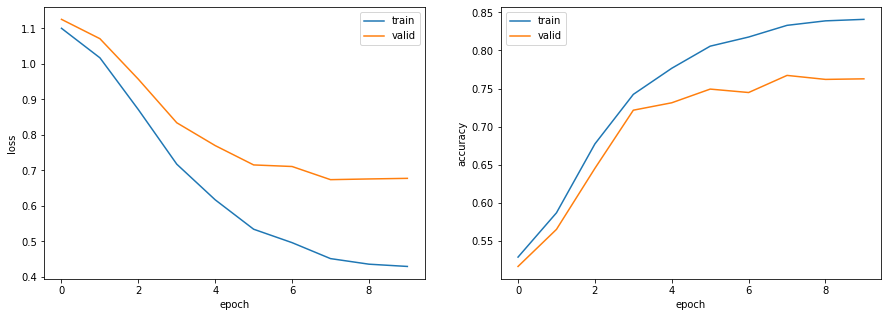

正解率（学習データ）：0.841
正解率（評価データ）：0.769


In [82]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 83. ミニバッチ化・GPU上での学習
***
問題82のコードを改変し，$B$事例ごとに損失・勾配を計算して学習を行えるようにせよ（$B$の値は適当に選べ）．また，GPU上で学習を実行せよ．

In [86]:
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

In [87]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
#device = torch.device('cuda')
device = torch.device('cpu')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

TypeError: __init__() missing 1 required positional argument: 'num_layers'

In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 84. 単語ベクトルの導入
***
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル）で単語埋め込み$emb(x)$を初期化し，学習せよ．

In [ ]:
# 学習済み単語ベクトルのダウンロード
FILE_ID = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
FILE_NAME = "GoogleNews-vectors-negative300.bin.gz"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILE_ID" -O $FILE_NAME && rm -rf /tmp/cookies.txt

In [ ]:
from gensim.models import KeyedVectors

# 学習済みモデルのロード
model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
  try:
    weights[i] = model[word]
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

In [ ]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)
    
  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out
    
  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size)
    return hidden

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
#device = torch.device('cuda')
device = torch.device('cpu')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

# No85